<a href="https://colab.research.google.com/github/rahiakela/pytorch-computer-vision-cookbook/blob/main/5-multi-object-detection/multi_object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Object Detection

Object detection is the process of locating and classifying existing objects in an image. Identified objects are shown with bounding boxes in the image. There are two methods for general object detection: region proposal-based and regression/classification-based. 

In this notebook, we will use a regression/classification-based method called YOLO.we will learn how to implement the YOLO-v3 algorithm and train and
deploy it for object detection using PyTorch.


## Setup

In [1]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
from torchvision.transforms.functional import to_pil_image
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau


import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.__version__)

from PIL import Image, ImageDraw, ImageFont

import copy
import os
import random
import numpy as np
import matplotlib.pylab as plt

%matplotlib inline

1.7.0+cu101


## Creating datasets

We will need to download the COCO dataset.

In [12]:
# rm -rf coco

In [ ]:
%%shell

# Download the following GitHub repository
git clone https://github.com/pjreddie/darknet

# Create a folder named data
mkdir data

# copy the get_coco_dataset.sh file
cp darknet/scripts/get_coco_dataset.sh data

# execute the get_coco_dataset.sh file
chmod 755 data/get_coco_dataset.sh
./data/get_coco_dataset.sh

# Create a folder named config
mkdir data/config
# copy the yolov3.cfg file
cp darknet/cfg/yolov3.cfg data/config/

# Finally, download the coco.names file and put it in the data folder
wget https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names
cp coco.names data/

### Creating a custom COCO dataset

Now that we've downloaded the COCO dataset, we will create training and validation datasets and dataloaders using PyTorch's Dataset and Dataloader classes.

we will define the CocoDataset class and show some sample images from
the training and validation datasets.

In [17]:
class CocoDataset(Dataset):

  def __init__(self, files_path, transform=None, trans_params=None):
    # get list of images
    with open(files_path, "r") as file:
      self.img_path = file.readlines()
    # get list of labels
    self.label_path = [path.replace("images", "labels").replace(".png", "txt").replace(".jpg", ".txt") for path in self.img_path]
    self.trans_params = trans_params 
    self.transform = transform 

  def __len__(self):
    return len(self.img_path)

  def __getitem__(self, index):
    img_path = self.img_path[index % len(self.img_path)].rstrip()
    img = Image.open(img_path).convert("RGB")
    label_path = self.label_path[index % len(self.img_path)].rstrip()

    labels = None
    if os.path.exists(label_path):
      labels = np.loadtxt(label_path).reshape(-1, 5)
    if self.transform:
      img, labels = self.transform(img, labels, self.trans_params)

    return img, labels, img_path

Next, we will create an object of the CocoDataset class for the validation data:

In [18]:
root_data = "coco"
train_file_path = os.path.join(root_data, "trainvalno5k.txt")
coco_train = CocoDataset(train_file_path)
print(len(coco_train))

117264


In [19]:
# Get a sample item from coco_val:
img, labels, img_path = coco_train[1] 
print("image size:", img.size, type(img))
print("labels shape:", labels.shape, type(labels))
print("labels \n", labels)

image size: (640, 426) <class 'PIL.Image.Image'>
labels shape: (2, 5) <class 'numpy.ndarray'>
labels 
 [[23.        0.770336  0.489695  0.335891  0.697559]
 [23.        0.185977  0.901608  0.206297  0.129554]]


Let's display a sample image from the coco_train and coco_val datasets.

In [20]:
val_file_path = os.path.join(root_data, "5k.txt")
coco_val = CocoDataset(val_file_path, transform=None, trans_params=None)
print(len(coco_val))

5000


In [21]:
# Get a sample item from coco_val:
img, labels, img_path = coco_val[7] 
print("image size:", img.size, type(img))
print("labels shape:", labels.shape, type(labels))
print("labels \n", labels)

image size: (640, 427) <class 'PIL.Image.Image'>
labels shape: (3, 5) <class 'numpy.ndarray'>
labels 
 [[20.        0.539742  0.521429  0.758641  0.957143]
 [20.        0.403469  0.470714  0.641656  0.695948]
 [20.        0.853039  0.493279  0.293922  0.982061]]


Let's display a sample image from the coco_train and coco_val datasets.

In [28]:
# Get a list of COCO object names
coco_names_path="./data/coco.names"
fp = open(coco_names_path, "r")
coco_names = fp.read().split("\n")[:-1]
print("number of classese:", len(coco_names))
print(coco_names)

number of classese: 80
['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [29]:
# Define a rescale_bbox helper function to rescale normalized bounding boxes to the original image size
def rescale_bbox(bb, W, H):
  x, y, w, h = bb
  return [x * W, y * H, w * W, h * H]

In [ ]:
!wget https://github.com/python-pillow/Pillow/raw/master/Tests/fonts/FreeMono.ttf

In [35]:
# Define the show_img_bbox helper function to show an image with object bounding boxes
COLORS = np.random.randint(0, 255, size=(80, 3),dtype="uint8")
# if the font that's passed to ImageFont.truetype is not available
# Alternatively, you may use a more common font
#fnt = ImageFont.truetype('arial.ttf', 16)
fnt = ImageFont.truetype('FreeMono.ttf', 16)

def show_img_bbox(img, targets):
  if torch.is_tensor(img):
      img=to_pil_image(img)
  if torch.is_tensor(targets):
      targets=targets.numpy()[:,1:]
      
  W, H=img.size
  draw = ImageDraw.Draw(img)
  
  for target in targets:
      id_=int(target[0])
      bbox=target[1:]
      bbox=rescale_bbox(bbox,W,H)
      xc, yc, w, h=bbox
      
      color = [int(c) for c in COLORS[id_]]
      name=coco_names[id_]
      
      draw.rectangle(((xc-w/2, yc-h/2), (xc+w/2, yc+h/2)), outline=tuple(color), width=3)
      draw.text((xc-w/2, yc-h/2), name, font=fnt, fill=(255, 255, 255, 0))
  plt.imshow(np.array(img))

(640, 428) (2, 5)


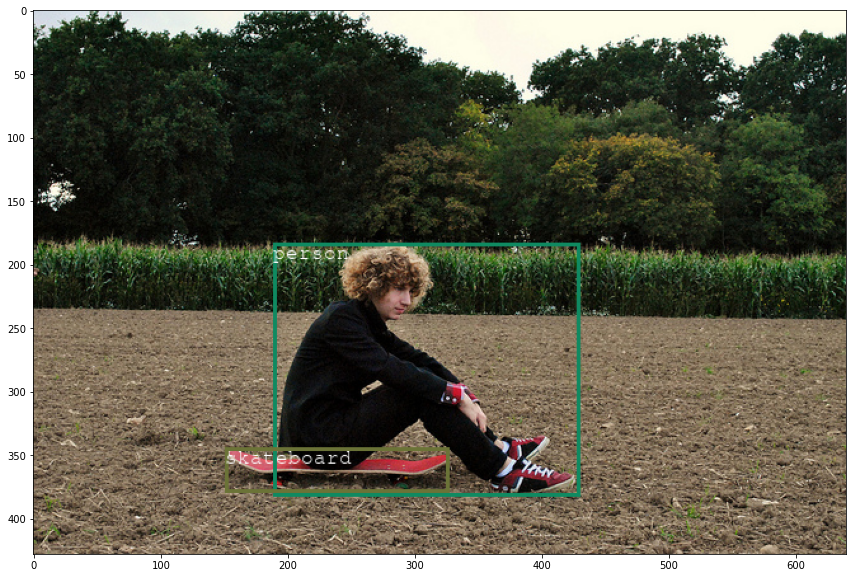

In [36]:
# Call the show_img_bbox helper function to show a sample image from coco_train
np.random.seed(2)
rnd_ind=np.random.randint(len(coco_train))
img, labels, img_path = coco_train[rnd_ind] 
print(img.size, labels.shape)

plt.rcParams['figure.figsize'] = (20, 10)
show_img_bbox(img, labels)

(640, 480) (3, 5)


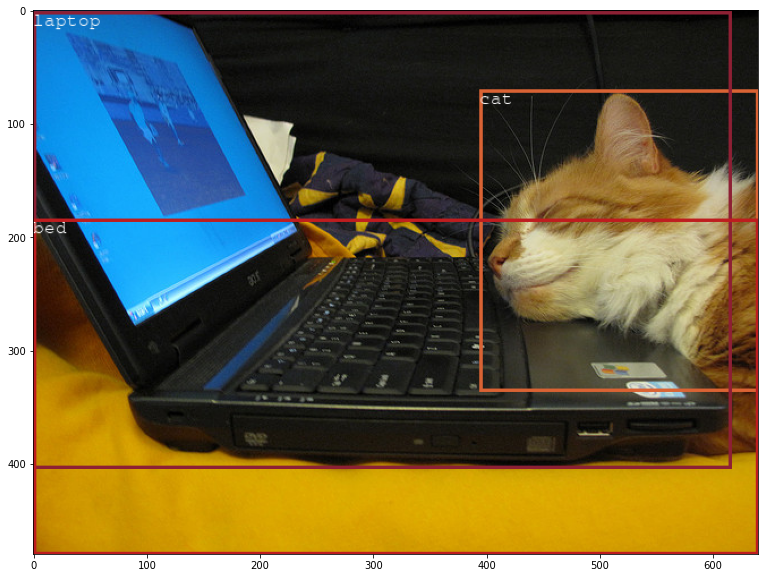

In [37]:
# Call the show_img_bbox helper function to show a sample image from coco_val
np.random.seed(0)
rnd_ind=np.random.randint(len(coco_val))
img, labels, img_path = coco_val[rnd_ind] 
print(img.size, labels.shape)

plt.rcParams['figure.figsize'] = (20, 10)
show_img_bbox(img, labels)

### Transforming data

In this section, we will define a transform function and the parameters to be passed to the CocoDataset class.

In the Transforming the data subsection, we defined the functions required for data transformation. These transformations were required to resize images, augment the data, or convert the data into PyTorch tensors.

In [38]:
# First, we will define a pad_to_square helper function
def pad_to_square(img, boxes, pad_value=0, normalized_labels=True):
  """
  img: A PIL image
  boxes: A numpy array with a shape of (n, 5) that contains n bounding boxes
  pad_value: The pixel fill value, which defaults to zero
  normalized_labels: A flag to show whether the bounding boxes were normalized to the range [0, 1]
  """
  w, h = img.size
  w_factor, h_factor = (w, h) if normalized_labels else (1, 1)

  # calculate the padding size and divided it into two values: pad1 and pad2
  dim_diff = np.abs(h - w)
  pad1 = dim_diff // 2
  pad2 = dim_diff - pad1

  if h <= w:
    left, top, right, bottom = 0, pad1, 0, pad2
  else:
    left, top, right, bottom = pad1, 0, pad2, 0
  padding = (left, top, right, bottom)

  # calculate the padding size on each side of the image
  img_padded = TF.pad(img, padding=padding, fill=pad_value)
  w_padded, h_padded = img_padded.size

  # adjust the bounding box coordinates based on the padding size.
  x1 = w_factor * (boxes[:, 1] - boxes[:, 3] / 2)
  y1 = h_factor * (boxes[:, 2] - boxes[:, 4] / 2)
  x2 = w_factor * (boxes[:, 1] + boxes[:, 3] / 2)
  y2 = h_factor * (boxes[:, 2] + boxes[:, 4] / 2)

  # Then, we adjusted x1, y1, x2, y2 by adding the padding sizes.
  x1 += padding[0]   # left
  y1 += padding[1]   # top
  x2 += padding[2]   # right
  y2 += padding[3]   # bottom

  # calculate the bounding boxes using the adjusted values of x1, y1, x2, y2.
  # Note that we normalized the labels again to the range of [0, 1].
  boxes[:, 1] = ((x1 + x2) / 2) / w_padded
  boxes[:, 2] = ((y1 + y2) / 2) / h_padded
  boxes[:, 3] *= w_factor / w_padded
  boxes[:, 4] *= h_factor / h_padded

  return img_padded, boxes

In [39]:
# Define the hflip helper function to horizontally flip images
def hflip(image, labels):
  image = TF.hflip(image)
  labels[:, 1] = 1.0 - labels[:, 1]

  return image, labels

In [40]:
# Define the transformer function
def transformer(image, labels, params):
  """
  image: A PIL image
  labels: Bounding boxes as a numpy array that's (n, 5) in size
  params: A Python dictionary containing the transformation parameters
  """
  if params["pad2square"] is True:
    image, labels = pad_to_square(image, labels)
  image = TF.resize(image, params["target_size"])

  if random.random() < params["p_hflip"]:
    image, labels = hflip(image, labels)   # randomly flip the image for data augmentation

  image = TF.to_tensor(image)              # convert the PIL image into a PyTorch tensor
  targets = torch.zeros((len(labels), 6))  # also convert into a PyTorch tensor of size n*6. The extra dimension will be used to index images in a mini-batch.
  targets[:, 1:] = torch.from_numpy(labels)

  return image, targets

We redefined `coco_train`; however, this time, we passed transformer and
`trans_params_train` to the CocoDataset class. To force the horizontal flip, we set the `p_hflip` probability to 1.0. In practice, we usually set the probability to 0.5. You can see the effect of the transformations on the sample image. The image has been zero-padded from the top and bottom, resized to 416*416, and horizontally flipped.

In [42]:
# Now, let's create an object of CocoDataset for training data by passing the transformer
trans_params_train = {
    "target_size": (416, 416),
    "pad2square": True,
    "p_hflip": 1.0,
    "normalized_labels": True
}

coco_train = CocoDataset(train_file_path, transform=transformer, trans_params=trans_params_train)

image shape: torch.Size([3, 416, 416])
labels shape: torch.Size([2, 6])


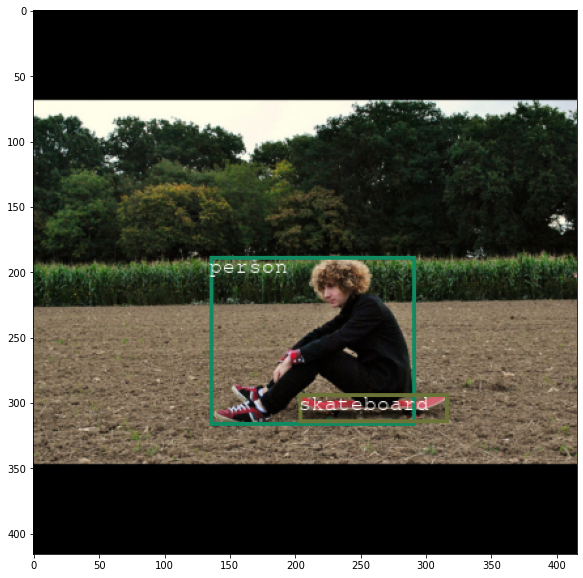

In [43]:
np.random.seed(2)
rnd_ind = np.random.randint(len(coco_train))
img, targets, img_path = coco_train[rnd_ind]
print("image shape:", img.shape)
print("labels shape:", targets.shape)

plt.rcParams['figure.figsize'] = (20, 10)
COLORS = np.random.randint(0, 255, size=(80, 3),dtype="uint8")
show_img_bbox(img,targets)

Similarly, we redefined coco_val. We did not need data augmentation for the
validation data, so we set the probability of p_hflip to 0.0. Check out the transformed sample size. It has been zero-padded from the top and bottom and resized to 416*416 but not flipped.

In [44]:
# Similarly, we will define an object of CocoDataset by passing the transformer to validate the data
trans_params_val = {
    "target_size": (416, 416),
    "pad2square": True,
    "p_hflip": 0.0,
    "normalized_labels": True
}

coco_val = CocoDataset(val_file_path, transform=transformer, trans_params=trans_params_val)

image shape: torch.Size([3, 416, 416])
labels shape: torch.Size([2, 6])


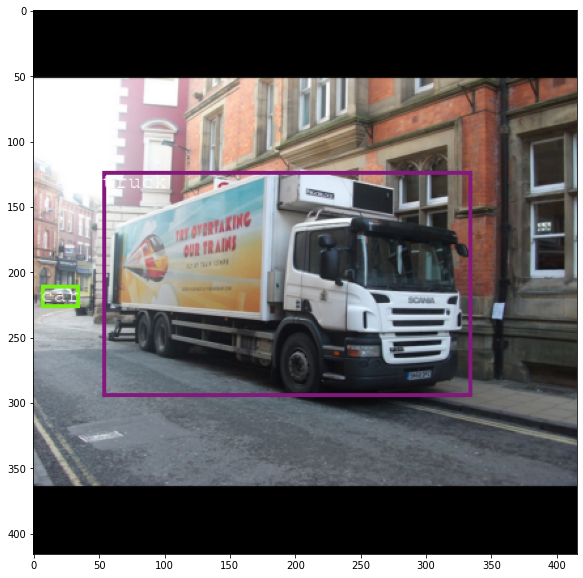

In [45]:
np.random.seed(2)
rnd_ind = np.random.randint(len(coco_val))
img, targets, img_path = coco_val[rnd_ind]
print("image shape:", img.shape)
print("labels shape:", targets.shape)

plt.rcParams['figure.figsize'] = (20, 10)
COLORS = np.random.randint(0, 255, size=(80, 3),dtype="uint8")
show_img_bbox(img,targets)

### Defining the Dataloaders

We will define two dataloaders for training and validation of datasets so we
can get mini-batches of data from coco_train and coco_val.

We also defined the collate_fn function to process a mini-batch and return
PyTorch tensors. The function was given as an argument to the Dataloader class so that the process happens on the fly. In the function, we grouped the images, targets, and paths in the mini-batch using zip(*iterateble). Then, we removed any empty bounding boxes in the targets. Next, we set the sample index in the mini-batch. Finally, we concatenated the images and targets as PyTorch tensors. To see how this works, we extracted a mini-batch from train_dl and val_dl and printed the shape of the returned tensors.

Define an object of the Dataloader class for the training data.

In [46]:
batch_size = 8

def collate_fn(batch):
  imgs, targets, paths = list(zip(*batch))

  # Remove empty boxes
  targets = [boxes for boxes in targets if boxes is not None]

  # set the sample index
  for b_i, boxes in enumerate(targets):
    boxes[:, 0] = b_i
  targets = torch.cat(targets, 0)
  imgs = torch.stack([img for img in imgs])

  return imgs, targets, paths

In [47]:
train_dataloader = DataLoader(coco_train, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True, collate_fn=collate_fn)

Let's extract a mini-batch from train_dataloader.

In [48]:
torch.manual_seed(0)

for imgs_batch, target_batch, path_batch in train_dataloader:
  break

print(imgs_batch.shape)
print(target_batch.shape, target_batch.dtype)

torch.Size([8, 3, 416, 416])
torch.Size([82, 6]) torch.float32


Define an object of the Dataloader class for the validation data.

In [49]:
val_dataloader = DataLoader(coco_val, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True, collate_fn=collate_fn)

Let's extract a mini-batch from val_dataloader:

In [50]:
torch.manual_seed(0)

for imgs_batch, target_batch, path_batch in val_dataloader:
  break

print(imgs_batch.shape)
print(target_batch.shape, target_batch.dtype)

torch.Size([8, 3, 416, 416])
torch.Size([83, 6]) torch.float32


## Creating a YOLO-v3 model

The YOLO-v3 network is built of convolutional layers with stride 2, skip connections, and up-sampling layers. There are no pooling layers. The network receives an image whose size is 416*416 as input and provides three YOLO outputs.

<img src='https://github.com/rahiakela/img-repo/blob/master/object-detection-images/yolo-v3.png?raw=1' width='800'/>

The network down-samples the input image by a factor of 32 to a feature map of
size `13*13`, where `yolo-out1` is provided. To improve the detection performance, the `13*13` feature map is up-sampled to `26*26` and `52*52`, where we have `yolo-out2` and `yolo-out3`, respectively. A cell in a feature map predicts three bounding boxes that correspond to three predefined anchors. As a result, the network predicts `13*13*3+26*26*3+52*52*3=10647` bounding boxes in total.

A bounding box is defined using 85 numbers:
- Four coordinates, `[x, y, w, h]`
- An abjectness score
- `C=80` class predictions corresponding to 80 object categories in the COCO
dataset




### Parsing the configuration file

We need to parse the configuration file to be able to build the model. We have provided a `myutils.py` file that contains a helper function with which you can do this. The configuration file `yolov3.cfg` was downloaded previously in the Creating Datasets:

In [51]:
!wget https://raw.githubusercontent.com/rahiakela/pytorch-computer-vision-cookbook/main/5-multi-object-detection/myutils.py

--2021-02-15 11:13:59--  https://raw.githubusercontent.com/rahiakela/pytorch-computer-vision-cookbook/main/5-multi-object-detection/myutils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6302 (6.2K) [text/plain]
Saving to: ‘myutils.py’

myutils.py          100%[===================>]   6.15K  --.-KB/s    in 0s      

2021-02-15 11:13:59 (73.4 MB/s) - ‘myutils.py’ saved [6302/6302]



In [52]:
from myutils import parse_model_config, create_layers

In [54]:
config_path = "./data/config/yolov3.cfg"
blocks_list = parse_model_config(config_path)
blocks_list[:2]

[{'angle': '0',
  'batch': '64',
  'burn_in': '1000',
  'channels': '3',
  'decay': '0.0005',
  'exposure': '1.5',
  'height': '608',
  'hue': '.1',
  'learning_rate': '0.001',
  'max_batches': '500200',
  'momentum': '0.9',
  'policy': 'steps',
  'saturation': '1.5',
  'scales': '.1,.1',
  'steps': '400000,450000',
  'subdivisions': '16',
  'type': 'net',
  'width': '608'},
 {'activation': 'leaky',
  'batch_normalize': '1',
  'filters': '32',
  'pad': '1',
  'size': '3',
  'stride': '1',
  'type': 'convolutional'}]

### Creating PyTorch modules

we will create PyTorch modules based on our parsed configuration file.

Now, let's call the create_layers function and get a list of PyTorch modules.

In [55]:
hyper_parameters, model_list = create_layers(blocks_list)
print(model_list),
print(hyper_parameters)

ModuleList(
  (0): Sequential(
    (conv_0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (batch_norm_0): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (leaky_0): LeakyReLU(negative_slope=0.1)
  )
  (1): Sequential(
    (conv_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (batch_norm_1): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (leaky_1): LeakyReLU(negative_slope=0.1)
  )
  (2): Sequential(
    (conv_2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (batch_norm_2): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (leaky_2): LeakyReLU(negative_slope=0.1)
  )
  (3): Sequential(
    (conv_3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (batch_norm_3): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (leaky_3):

### Defining the Darknet model

Now, let's learn how to define the Darknet class.

In [56]:
class Darknet(torch.nn.Module):

  def __init__(self, config_path, img_size=416):
    super(Darknet, self).__init__()
    self.blocks_list = parse_model_config(config_path)
    self.hyperparameters, self.module_list = create_layers(self.blocks_list)
    self.img_size = img_size

  def forward(self, x):
    img_dim = x.shape[2]
    layer_outputs, yolo_outputs = [], []

    for block, module in zip(self.blocks_list[1:], self.module_list):
      if block["type"] in ["convolutional", "upsample", "maxpool"]:
         x = module(x)
      elif block["type"] == "shortcut":
        layer_ind = int(block["from"])
        x = layer_outputs[-1] + layer_outputs[layer_ind]
      elif block["type"] == "yolo":
        x = module[0](x)
        yolo_outputs.append(x)
      elif block["type"] == "route":
        x = torch.cat([layer_outputs[int(l_i)] for l_i in block["layers"].split(",")], 1)

      layer_outputs.append(x)

    yolo_out_cat = torch.cat(yolo_outputs, 1)

    return yolo_out_cat, yolo_outputs

Let's create an object of the Darknet class.

In [57]:
model = Darknet(config_path).to(device)
print(model)

Darknet(
  (module_list): ModuleList(
    (0): Sequential(
      (conv_0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_0): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (leaky_0): LeakyReLU(negative_slope=0.1)
    )
    (1): Sequential(
      (conv_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (batch_norm_1): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (leaky_1): LeakyReLU(negative_slope=0.1)
    )
    (2): Sequential(
      (conv_2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (batch_norm_2): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (leaky_2): LeakyReLU(negative_slope=0.1)
    )
    (3): Sequential(
      (conv_3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_3): BatchNorm2d(64, eps=1e-05, momen

In [58]:
print(next(model.parameters()).to(device))

Parameter containing:
tensor([[[[-1.2019e-01, -1.1034e-01, -1.4896e-01],
          [-4.8049e-02,  1.5748e-01,  8.0663e-02],
          [-1.0249e-01,  4.2263e-02, -4.6673e-02]],

         [[-1.4780e-01,  1.0847e-01,  1.2237e-01],
          [-1.0564e-01,  2.8883e-02, -6.7371e-03],
          [ 1.5736e-01, -6.2508e-02,  1.7088e-01]],

         [[ 4.3193e-02, -8.0825e-03, -5.2505e-02],
          [ 4.4978e-02,  3.2982e-02,  1.5771e-02],
          [ 1.8429e-01,  1.6410e-01,  1.3918e-01]]],


        [[[ 8.8997e-02, -2.7649e-02,  5.5101e-02],
          [-1.0512e-01, -1.2722e-01,  1.1406e-01],
          [-1.0828e-01,  2.0291e-02, -1.6365e-01]],

         [[ 8.3667e-02, -3.9062e-02,  7.0796e-02],
          [ 1.5665e-01,  1.7463e-01, -8.4511e-02],
          [ 1.5647e-01,  1.9209e-01,  9.3803e-02]],

         [[ 8.2506e-02,  1.4917e-01, -8.3050e-02],
          [ 9.1903e-03,  1.9261e-03,  1.0432e-01],
          [-9.5136e-02, -1.7992e-01,  6.2288e-03]]],


        [[[-9.6329e-02,  1.8286e-03,  2.5916

Next, let's test the model using a dummy input.

In [59]:
dummy_img = torch.rand(1, 3, 416, 416).to(device)
with torch.no_grad():
  dummy_out_cat, dummy_out = model.forward(dummy_img)
  print(dummy_out_cat.shape)
  print(dummy_out[0].shape, dummy_out[1].shape, dummy_out[2].shape)

torch.Size([1, 10647, 85])
torch.Size([1, 507, 85]) torch.Size([1, 2028, 85]) torch.Size([1, 8112, 85])


### Defining the loss function

we will define a loss function for the YOLO-v3 architecture. To get an insight
into of the YOLO-v3 loss, recall that the model output comprises the following elements:

- [x, y, w, h] of bounding boxes
- An objectness score
- Class predictions for 80 object categories

Thus, the YOLO-v3 loss function is composed of the following:

$$ loss = loss_x + loss_y + loss_w + loss_h + loss_{obj} + loss_{cls}$$

Here, we have the following:

- $loss_x, loss_y, loss_w, loss_h$ are the mean squared error of x, y, w, h
- $loss_{obj}$ is the binary cross-entropy loss of the objectness score
- $loss_{cls}$ is the binary cross-entropy loss of class predictions

Here, we will learn how to implement a combined loss function for the YOLO-v3
algorithm.

In [60]:
def get_loss_batch(output, targets, params_loss, opt=None):
  """
  output: A list of three tensors corresponding to the YOLO-v3 outputs.
  targets: The ground truth, a tensor of shape n*6, where n is the total number of bounding boxes in the batch.
  params_loss: A Python dict, which contains the loss parameters.
  opt: An object of the optimizer class. The default value is None.
  """
  # extract the parameters from the params_loss dictionary
  ignore_thres = params_loss["ignore_thres"]
  scaled_anchors = params_loss["scaled_anchors"]
  mse_loss = params_loss["mse_loss"]
  bce_loss = params_loss["bce_loss"]

  num_yolos = params_loss["num_yolos"]
  num_anchors = params_loss["num_anchors"]
  obj_scale = params_loss["obj_scale"]
  noobj_scale = params_loss["noobj_scale"]

  # In each iteration, we extracted the YOLO output (yolo_out), the number of bounding boxes (num_bboxs), and the grid size(gird_size)
  loss = 0.0
  for yolo_ind in range(num_yolos):
    yolo_out = output[yolo_ind]
    batch_size, num_bbxs, _ = yolo_out.shape

    # get grid size
    gz_2 = num_bbxs / num_anchors
    grid_size = int(np.sqrt(gz_2))

    yolo_out = yolo_out.view(batch_size, num_anchors, grid_size, grid_size, -1)

    # extracting the predicted bounding boxes
    pred_boxes = yolo_out[:, :, :, :, :4]
    x, y, w, h = transform_bbox(pred_boxes, scaled_anchors[yolo_ind])
    pred_conf = yolo_out[:, :, :, :, 4]
    pred_cls_prob = yolo_out[:, :, :, :, 5:]

    yolo_targets = get_yolo_targets({
        "pred_cls_prob": pred_cls_prob,
        "pred_boxes":pred_boxes,    
        "targets": targets,    
        "anchors": scaled_anchors[yolo_ind],    
        "ignore_thres": ignore_thres,
    })

    obj_mask=yolo_targets["obj_mask"]        
    noobj_mask=yolo_targets["noobj_mask"]            
    tx=yolo_targets["tx"]                
    ty=yolo_targets["ty"]                    
    tw=yolo_targets["tw"]                        
    th=yolo_targets["th"]                            
    tcls=yolo_targets["tcls"]                                
    t_conf=yolo_targets["t_conf"]

    # calculate the mean-squared error between the predicted and the target coordinates of the bounding boxes
    loss_x = mse_loss(x[obj_mask], tx[obj_mask])
    loss_y = mse_loss(y[obj_mask], ty[obj_mask])
    loss_w = mse_loss(w[obj_mask], tw[obj_mask])
    loss_h = mse_loss(h[obj_mask], th[obj_mask])

    # calculate the binary cross-entropy loss between the predicted and target objectness scores.
    loss_conf_obj = bce_loss(pred_conf[obj_mask], t_conf[obj_mask])
    loss_conf_noobj = bce_loss(pred_conf[noobj_mask], t_conf[noobj_mask])
    loss_conf = obj_scale * loss_conf_obj + noobj_scale * loss_conf_noobj
    loss_cls = bce_loss(pred_cls_prob[obj_mask], tcls[obj_mask])
    # Finally, all the calculated loss values were summed together.
    loss += loss_x + loss_y + loss_w + loss_h + loss_conf + loss_cls

  # If the optimization object, has a value, we compute the gradients and perform the
  # optimization step; otherwise, we return the total loss.
  if opt is not None:
    opt.zero_grad()
    loss.backward()
    opt.step

  return loss.item()

In [61]:
def transform_bbox(bbox, anchors):
  """
  This function takes the predicted bounding boxes and transforms them so that they're
  compatible with the target values. This transformation is the reverse
  of the transform_outputs function from the YOLOLayer class.

  bbox: A tensor of shape (batch_size, 3, grid_size, grid_size, 4) that contains the predicted bounding boxes.
  anchors: A tensor of shape (3, 2) that contains the scaled widths and heights of the three anchors for each YOLO output.
  """
  # extract the x, y, w, h tensors from bbox.
  x=bbox[:,:,:,:,0]
  y=bbox[:,:,:,:,1]
  w=bbox[:,:,:,:,2]
  h=bbox[:,:,:,:,3]
  # Then, we sliced the two columns of the anchors tensor and reshaped them into tensors of shape(1, 3, 1, 1)
  anchor_w = anchors[:, 0].view((1, 3, 1, 1))
  anchor_h = anchors[:, 1].view((1, 3, 1, 1))       
  
  # Next, we transformed the values and returned a list of four tensors corresponding to x, y, w, h.
  x=x-x.floor()
  y=y-y.floor()
  w= torch.log(w / anchor_w + 1e-16)
  h= torch.log(h / anchor_h + 1e-16)

  return x, y, w, h

In [76]:
def get_yolo_targets(params):
  """
  pred_boxes: A tensor of shape (batch_size, 3, grid_size, grid_size, 4) that contains the predicted bounding boxes.
  pred_cls_prob: A tensor of shape (batch_size, 3, grid_size, grid_size, 80) that contains the predicted class probabilities.
  targets: A tensor of shape (n, 6), where n is the number of bounding boxes in a batch, containing the ground truth bounding boxes and labels.
  anchors: A tensor of shape (2, 3) that contains the scaled width and height of the three anchors.
  ignore_thres: A scalar float value set to 0.5, which is used as the threshold value.
  """
  pred_boxes=params["pred_boxes"]
  pred_cls_prob=params["pred_cls_prob"]
  target=params["targets"]
  anchors=params["anchors"] 
  ignore_thres=params["ignore_thres"] 

  batch_size = pred_boxes.size(0)
  num_anchors = pred_boxes.size(1)
  grid_size = pred_boxes.size(2)
  num_cls = pred_cls_prob.size(-1)

  # nitializing the output tensors
  sizeT=batch_size, num_anchors, grid_size, grid_size
  obj_mask = torch.zeros(sizeT,device=device,dtype=torch.uint8)
  noobj_mask = torch.ones(sizeT,device=device,dtype=torch.uint8)
  tx = torch.zeros(sizeT, device=device, dtype=torch.float32)
  ty= torch.zeros(sizeT, device=device, dtype=torch.float32)
  tw= torch.zeros(sizeT, device=device, dtype=torch.float32)
  th= torch.zeros(sizeT, device=device, dtype=torch.float32)

  sizeT=batch_size, num_anchors, grid_size, grid_size, num_cls
  tcls= torch.zeros(sizeT, device=device, dtype=torch.float32)

  # Then, we sliced the target bounding boxes from the target tensor and scaled by the grid size. 
  target_bboxes = target[:, 2:] * grid_size
  t_xy = target_bboxes[:, :2]
  t_wh = target_bboxes[:, 2:]
  t_x, t_y = t_xy.t()
  t_w, t_h = t_wh.t()

  grid_i, grid_j = t_xy.long().t()

  # Next, we calculated the intersection over union (IoU) of a target and the three anchors
  iou_with_anchors = [get_iou_WH(anchor, t_wh) for anchor in anchors]
  iou_with_anchors = torch.stack(iou_with_anchors)
  # Then, we found the anchor that has the highest IOU with a target.
  best_iou_wa, best_anchor_ind = iou_with_anchors.max(0)

  # setting the object mask tensors
  batch_inds, target_labels = target[:, :2].long().t()
  obj_mask[batch_inds, best_anchor_ind, grid_j, grid_i] = 1
  noobj_mask[batch_inds, best_anchor_ind, grid_j, grid_i] = 0

  for ind, iou_wa in enumerate(iou_with_anchors.t()):
    noobj_mask[batch_inds[ind], iou_wa > ignore_thres, grid_j[ind], grid_i[ind]] = 0
  
  # setting x and y
  tx[batch_inds, best_anchor_ind, grid_j, grid_i] = t_x - t_x.floor()
  ty[batch_inds, best_anchor_ind, grid_j, grid_i] = t_y - t_y.floor()

  # setting w and h
  anchor_w=anchors[best_anchor_ind][:, 0]
  tw[batch_inds, best_anchor_ind, grid_j, grid_i] = torch.log(t_w / anchor_w + 1e-16)
  
  anchor_h=anchors[best_anchor_ind][:, 1]
  th[batch_inds, best_anchor_ind, grid_j, grid_i] = torch.log(t_h / anchor_h + 1e-16)
  
  # setting target classes
  tcls[batch_inds, best_anchor_ind, grid_j, grid_i, target_labels] = 1

  output = {
      "obj_mask" : obj_mask,
      "noobj_mask" : noobj_mask,
      "tx": tx,
      "ty": ty,
      "tw": tw,
      "th": th,
      "tcls": tcls,
      "t_conf": obj_mask.float(),
  }

  return output

In [63]:
def get_iou_WH(wh1, wh2):
  wh2 = wh2.t()
  w1, h1 = wh1[0], wh1[1]
  w2, h2 = wh2[0], wh2[1]
  inter_area = torch.min(w1, w2) * torch.min(h1, h2)
  union_area = (w1 * h1 + 1e-16) + w2 * h2 - inter_area
  
  return inter_area / union_area

## Training the model

The training process will follow the standard stochastic gradient descent (SGD) process. We will train the model on the training data and evaluate it on the validation data. Due to the large size of the COCO dataset and our deep model of the YOLO-v3 architecture, training will be very slow, even when using a GPU. You may need to train the model for up to a week to get good performance.

In [64]:
def loss_epoch(model, params_loss, dataset_dl, sanity_check=False, opt=None):
  running_loss = 0.0
  len_data = len(dataset_dl.dataset)
  running_metrics = {}

  for xb, yb, _ in dataset_dl:
    yb = yb.to(device)
    _, output = model(xb.to(device))
    loss_b = get_loss_batch(output, yb, params_loss, opt)
    running_loss += loss_b
    if sanity_check is True:
      break
  
  loss = running_loss / float(len_data)

  return loss 

In [65]:
def train_val(model, params):
  num_epochs=params["num_epochs"]
  params_loss=params["params_loss"]
  opt=params["optimizer"]
  train_dl=params["train_dl"]
  val_dl=params["val_dl"]
  sanity_check=params["sanity_check"]
  lr_scheduler=params["lr_scheduler"]
  path2weights=params["path2weights"]

  loss_history = {
      "train": [],
      "val": [],
  }

  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = float("inf")

  for epoch in range(num_epochs):
    current_lr = get_lr(opt)
    print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs - 1, current_lr))
    model.train()
    train_loss = loss_epoch(model, params_loss, train_dl, sanity_check, opt)
    loss_history["train"].append(train_loss)
    print("train loss: %.6f" %(train_loss))

    model.eval()
    with torch.no_grad():
      val_loss = loss_epoch(model, params_loss, val_dl, sanity_check)
    loss_history["val"].append(val_loss)
    print("val loss: %.6f" %(val_loss))

    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())
      torch.save(model.state_dict(), path2weights)
      print("Copied best model weights!")

    lr_scheduler.step(val_loss)
    if current_lr != get_lr(opt):
      print("Loading best model weights!")
      model.load_state_dict(best_model_wts) 
    print("-"*10) 
  
  model.load_state_dict(best_model_wts)

  return model, loss_history

In [66]:
def get_lr(opt):
  for param_group in opt.param_groups:
      return param_group['lr']

In [67]:
# let's define the optimizer
# use the learning scheduler to monitor the loss and reduce the learning rate in the case of plateaus.
opt = optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = ReduceLROnPlateau(opt, mode="min", factor=0.5, patience=20, verbose=1)

model_path = "./models/"
if not os.path.exists(model_path):
  os.mkdir(model_path)

scaled_anchors = [
    model.module_list[82][0].scaled_anchors,
    model.module_list[94][0].scaled_anchors,
    model.module_list[106][0].scaled_anchors               
]

In [69]:
import torch.nn as nn

In [78]:
# Then, we will set the loss parameters
mse_loss = nn.MSELoss(reduction="sum")
bce_loss = nn.BCELoss(reduction="sum")
params_loss = {
    "scaled_anchors" : scaled_anchors,
    "ignore_thres": 0.5,
    "mse_loss": mse_loss,
    "bce_loss": bce_loss,
    "num_yolos": 3,
    "num_anchors": 3,
    "obj_scale": 1,
    "noobj_scale": 100,
}

# Next, we will set the training parameters
params_train = {
    "num_epochs": 100,
    "optimizer": opt,
    "params_loss": params_loss,
    "train_dl": train_dataloader,
    "val_dl": val_dataloader,
    "sanity_check": True,
    "lr_scheduler": lr_scheduler,
    "path2weights": model_path +"weights.pt",
}

Depending on your computer's capability, you may get an out-of-memory error while running the preceding snippet.

>>If you get an out of memory error on your computer, try to reduce the
batch size and restart the notebook.



In [79]:
model, loss_hist=train_val(model, params_train)

Epoch 0/99, current lr=0.001


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:25.)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:25.)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:25.)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:25.)
/usr/local/lib/pytho

train loss: 55.140422
val loss: 1299.523000
Copied best model weights!
----------
Epoch 1/99, current lr=0.001
train loss: 55.633263
val loss: 1302.807200
----------
Epoch 2/99, current lr=0.001
train loss: 55.060556
val loss: 1284.713000
Copied best model weights!
----------
Epoch 3/99, current lr=0.001
train loss: 55.522496
val loss: 1282.980700
Copied best model weights!
----------
Epoch 4/99, current lr=0.001
train loss: 55.382283
val loss: 1283.549200
----------
Epoch 5/99, current lr=0.001
train loss: 55.382684
val loss: 1300.907000
----------
Epoch 6/99, current lr=0.001
train loss: 55.315766
val loss: 1254.538000
Copied best model weights!
----------
Epoch 7/99, current lr=0.001
train loss: 55.543347
val loss: 1272.445600
----------
Epoch 8/99, current lr=0.001
train loss: 55.105386
val loss: 1303.249700
----------
Epoch 9/99, current lr=0.001
train loss: 55.327308
val loss: 1311.022900
----------
Epoch 10/99, current lr=0.001
train loss: 55.782840
val loss: 1273.420000
-------

## Deploying the model

Now that training is complete, it is time to deploy the model. To deploy the model, we need to define the model class, as described in the Creating the YOLOv3 model recipe. Then, we need to load the trained weights into the model and deploy it on the validation dataset.

In this recipe, you will learn how to load weights into the model, deploy it on a sample image, and display the results.

1. Load trained weights into the model:

In [80]:
weights_path = "./models/weights.pt"
model.load_state_dict(torch.load(weights_path))

<All keys matched successfully>

2. Get a sample image from the validation dataset:

In [81]:
img, tag, _ = coco_val[4]
print(img.shape)
print(tag.shape)

torch.Size([3, 416, 416])
torch.Size([2, 6])


3. Let's display the image and its bounding boxes:

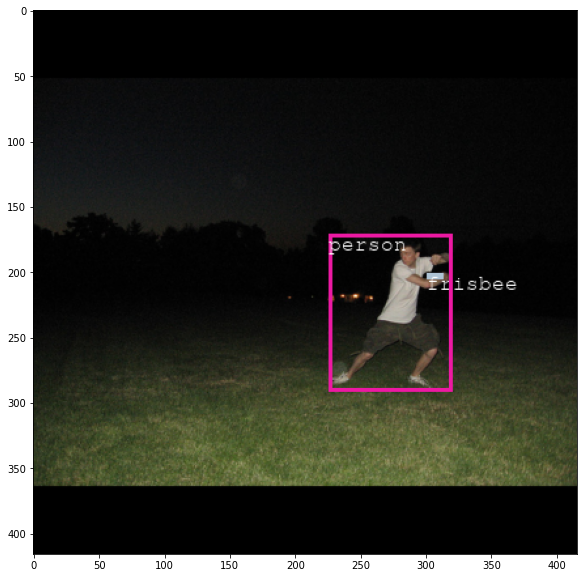

In [82]:
show_img_bbox(img, tag)

As we can see, the image has a person and a frisbee.

4. Now, let's feed the image to the model to get the output:

In [89]:
model.eval()
with torch.no_grad():
  out, _ = model(img.unsqueeze(0).to(device))
print(out.shape)

torch.Size([1, 10647, 85])


5. Pass the model's output to the NonMaxSuppression function:

In [102]:
def NonMaxSuppression(bbox_pred, obj_threshold=0.5, nms_thres=0.5):
  bbox_pred[..., :4] = xywh2xyxy(bbox_pred[..., :4])
  output = [None] * len(bbox_pred)

  for ind, bb_pr in enumerate(bbox_pred):
      bb_pr = bb_pr[bb_pr[:, 4] >= obj_threshold]
      
      if not bb_pr.size(0):
          continue
          
      score = bb_pr[:, 4] * bb_pr[:, 5:].max(1)[0]
      bb_pr = bb_pr[(-score).argsort()]
      
      cls_probs, cls_preds = bb_pr[:, 5:].max(1, keepdim=True)
      detections = torch.cat((bb_pr[:, :5], 
                              cls_probs.float(), 
                              cls_preds.float()), 1)
      
      bbox_nms = []
      while detections.size(0):
          high_iou_inds = bbox_iou(detections[0, :4].unsqueeze(0), 
                                    detections[:, :4]) > nms_thres
          
          cls_match_inds = detections[0, -1] == detections[:, -1]
          supp_inds = high_iou_inds & cls_match_inds
          
          ww = detections[supp_inds, 4]
          # updated accoring to https://github.com/PacktPublishing/PyTorch-Computer-Vision-Cookbook/issues/6
          detections[0, :4] = (ww.view(-1, 1) * detections[supp_inds, :4]).sum(0) / ww.sum()
          
          bbox_nms += [detections[0]]
          detections = detections[~supp_inds]
          
      if bbox_nms:
          output[ind] = torch.stack(bbox_nms)
          output[ind]=xyxyh2xywh(output[ind])
  return output

In [103]:
def xywh2xyxy(xywh):
  xyxy = xywh.new(xywh.shape)
  xyxy[..., 0] = xywh[..., 0] - xywh[..., 2] / 2.0
  xyxy[..., 1] = xywh[..., 1] - xywh[..., 3] / 2.0
  xyxy[..., 2] = xywh[..., 0] + xywh[..., 2] / 2.0
  xyxy[..., 3] = xywh[..., 1] + xywh[..., 3] / 2.0
  return xyxy

In [104]:
def xyxyh2xywh(xyxy, image_size=416):
  xywh = torch.zeros(xyxy.shape[0],6)
  xywh[:,2] = (xyxy[:, 0] + xyxy[:, 2]) / 2./img_size
  xywh[:,3] = (xyxy[:, 1] + xyxy[:, 3]) / 2./img_size
  xywh[:,5] = (xyxy[:, 2] - xyxy[:, 0])/img_size 
  xywh[:,4] = (xyxy[:, 3] - xyxy[:, 1])/img_size
  xywh[:,1]= xyxy[:,6]    
  return xywh

In [105]:
def bbox_iou(box1, box2):
  b1_x1, b1_y1, b1_x2, b1_y2 = box1[:, 0], box1[:, 1], box1[:, 2], box1[:, 3]
  b2_x1, b2_y1, b2_x2, b2_y2 = box2[:, 0], box2[:, 1], box2[:, 2], box2[:, 3]
  inter_rect_x1 = torch.max(b1_x1, b2_x1)
  inter_rect_y1 = torch.max(b1_y1, b2_y1)
  inter_rect_x2 = torch.min(b1_x2, b2_x2)
  inter_rect_y2 = torch.min(b1_y2, b2_y2)
  inter_area = torch.clamp(inter_rect_x2 - inter_rect_x1 + 1, min=0) \
                  *torch.clamp(inter_rect_y2 - inter_rect_y1 + 1, min=0)
  b1_area = (b1_x2 - b1_x1 + 1.0) * (b1_y2 - b1_y1 + 1.0)
  b2_area = (b2_x2 - b2_x1 + 1.0) * (b2_y2 - b2_y1 + 1.0)
  iou = inter_area / (b1_area + b2_area - inter_area + 1e-16)
  return iou

In [106]:
img_size = 416
out_nms = NonMaxSuppression(out.cpu())
print(out_nms[0].shape)

torch.Size([1667, 6])


6. Let's show the image and predicted bounding box:

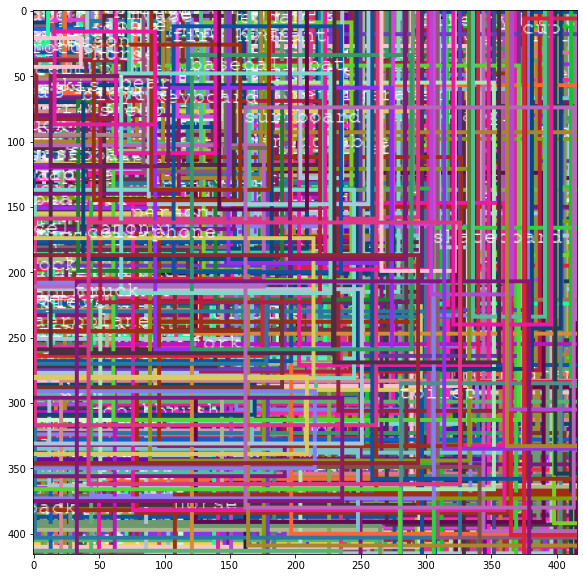

In [107]:
show_img_bbox(img, out_nms[0])